In [ ]:
import laspy
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from utilities import load_lidar, visualize, simulate_noise
from sklearn.model_selection import GridSearchCV



In [23]:
# Check the file structure
file_path = "./Data/300-5050_2015.las"

# Read the LAS file
las = laspy.read(file_path)

In [24]:
# Convert ALL laspy arrays to regular NumPy arrays
points_data = {
    'x': np.array(las.x),
    'y': np.array(las.y), 
    'z': np.array(las.z)
}

# Add intensity if available (convert to numpy)
if hasattr(las, 'intensity'):
    points_data['intensity'] = np.array(las.intensity)

# Add return information if available  
if hasattr(las, 'return_number') and hasattr(las, 'number_of_returns'):
    points_data['return_num'] = np.array(las.return_number)
    points_data['num_returns'] = np.array(las.number_of_returns)

# Add classification if available
if hasattr(las, 'classification'):
    points_data['classification'] = np.array(las.classification)

# Create DataFrame
points = pd.DataFrame(points_data)

print(f"DataFrame shape: {points.shape}")
print(f"Data types: {points.dtypes}")
print("\nFirst few points:")
print(points.head())

DataFrame shape: (15659171, 7)
Data types: x                 float64
y                 float64
z                 float64
intensity          uint16
return_num          uint8
num_returns         uint8
classification      uint8
dtype: object

First few points:
           x           y      z  intensity  return_num  num_returns  \
0  300465.22  5050036.03  43.03      20971           1            1   
1  300465.29  5050035.94  42.49      22937           1            1   
2  300465.42  5050035.76  42.16      24903           1            1   
3  300465.53  5050035.62  41.81      21626           1            1   
4  300465.64  5050035.47  41.46      22937           1            1   

   classification  
0               5  
1               4  
2               4  
3               4  
4               4  


In [17]:
# Extract a small segment of the data for testing
# Let's take points within a small bounding box
x_min, x_max = points['x'].min(), points['x'].max()
y_min, y_max = points['y'].min(), points['y'].max()

# Define a small segment (adjust these values based on your data distribution)
segment_size = 300  # meters - adjust this based on your data scale
segment_x_center = x_min + (x_max - x_min) * 0.1  # 10% from left edge
segment_y_center = y_min + (y_max - y_min) * 0.5  # 10% from bottom edge

# Create a small bounding box segment
segment_mask = (
    (points['x'] >= segment_x_center) & 
    (points['x'] <= segment_x_center + segment_size) &
    (points['y'] >= segment_y_center) & 
    (points['y'] <= segment_y_center + segment_size)
)

segment_points = points[segment_mask].copy()
print(f"Segment points: {len(segment_points):,}")
print(f"Original points: {len(points):,}")
print(f"Segment represents {len(segment_points)/len(points)*100:.2f}% of total data")

Segment points: 1,351,503
Original points: 15,659,171
Segment represents 8.63% of total data


In [25]:
# Take a 10% random sample of the original point cloud
import numpy as np

sample_frac = 0.10  # 10% sample
rng = np.random.default_rng(42)  # For reproducibility
sample_indices = rng.choice(points.index, size=int(len(points) * sample_frac), replace=False)
sampled_points = points.loc[sample_indices].copy()
print(f"Sampled {len(sampled_points):,} points out of {len(points):,} ({sample_frac*100:.0f}% of total)")

Sampled 1,565,917 points out of 15,659,171 (10% of total)


In [18]:
# Save segmented points to a new LAS file in Data/
import laspy
import os

output_path = os.path.join('Data', 'segmented_points_urban.las')

# Use the original LAS header for output, but update point count
header = las.header.copy()
header.point_count = len(segment_points)

# Create a new LasData object with the correct point count
new_las = laspy.LasData(header)

# Assign coordinates
new_las.x = segment_points['x'].values
new_las.y = segment_points['y'].values
new_las.z = segment_points['z'].values

# Copy optional attributes if present
for attr in ['intensity', 'classification', 'return_num', 'num_returns', 'gmm_cluster']:
    if attr in segment_points:
        setattr(new_las, attr, segment_points[attr].values)

# Save to file
new_las.write(output_path)
print(f"Segmented points saved to {output_path} ({len(segment_points):,} points)")

Segmented points saved to Data\segmented_points_urban.las (1,351,503 points)


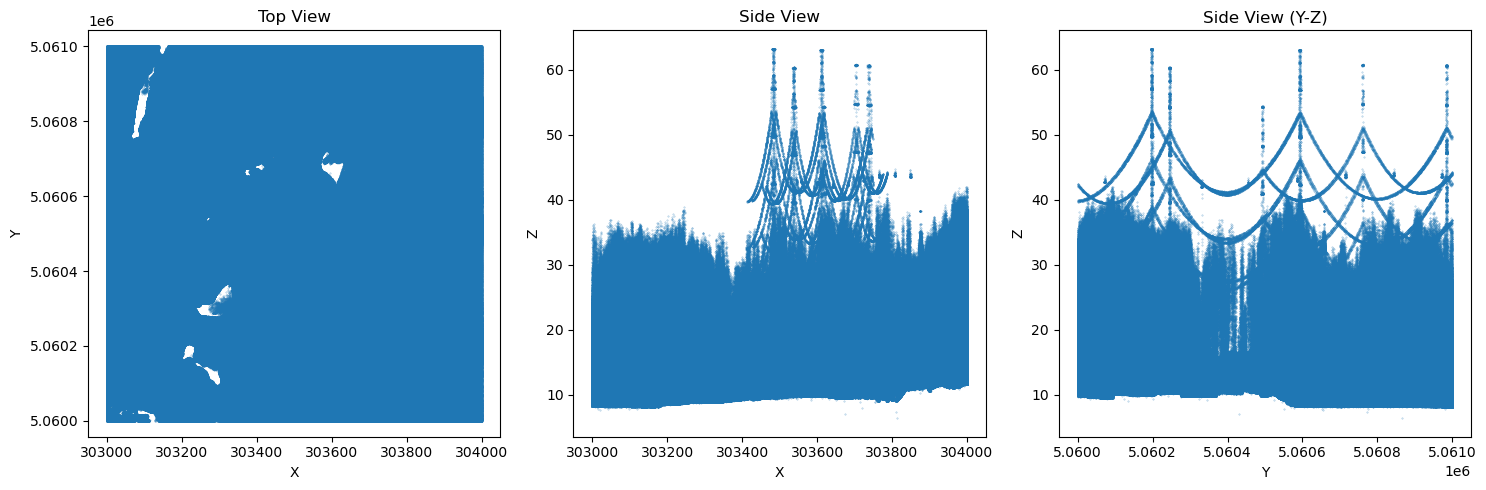

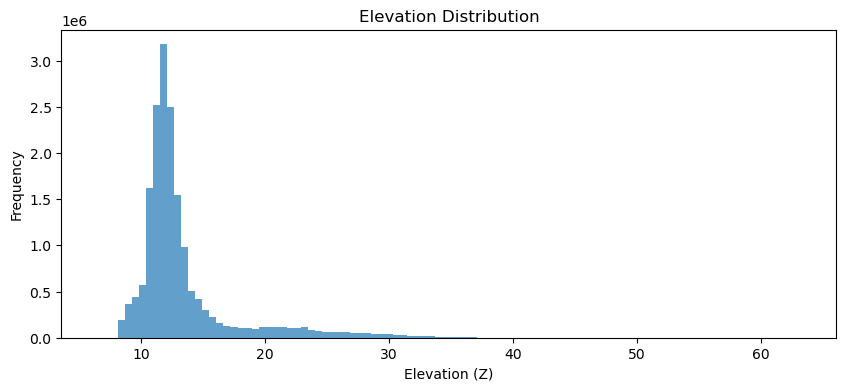

In [13]:
# Plot the point cloud (2D overview)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(points['x'].values, points['y'].values, s=0.1, alpha=0.5)  # Use .values to be safe
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Top View')
plt.axis('equal')

plt.subplot(132)
plt.scatter(points['x'].values, points['z'].values, s=0.1, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Side View')

plt.subplot(133)
plt.scatter(points['y'].values, points['z'].values, s=0.1, alpha=0.5)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Side View (Y-Z)')

plt.tight_layout()
plt.show()

# Height distribution
plt.figure(figsize=(10, 4))
plt.hist(points['z'].values, bins=100, alpha=0.7)
plt.xlabel('Elevation (Z)')
plt.ylabel('Frequency')
plt.title('Elevation Distribution')
plt.show()


Performing BIC analysis...
Fitting GMM with 1 components...
  Components: 1, BIC: 1026098.48, AIC: 1026011.08
Fitting GMM with 2 components...
  Components: 2, BIC: 957097.05, AIC: 956912.55
Fitting GMM with 3 components...
  Components: 3, BIC: 878021.39, AIC: 877739.80
Fitting GMM with 4 components...
  Components: 4, BIC: 803839.78, AIC: 803461.08
Fitting GMM with 5 components...
  Components: 5, BIC: 770724.22, AIC: 770248.42
Fitting GMM with 6 components...
  Components: 6, BIC: 756508.05, AIC: 755935.14
Fitting GMM with 7 components...
  Components: 7, BIC: 738033.24, AIC: 737363.23
Fitting GMM with 8 components...
  Components: 8, BIC: 705136.29, AIC: 704369.18
Fitting GMM with 9 components...
  Components: 9, BIC: 685871.30, AIC: 685007.09
Fitting GMM with 10 components...
  Components: 10, BIC: 648483.39, AIC: 647522.07
Fitting GMM with 11 components...
  Components: 11, BIC: 637124.35, AIC: 636065.94
Fitting GMM with 12 components...
  Components: 12, BIC: 629316.86, AIC: 62

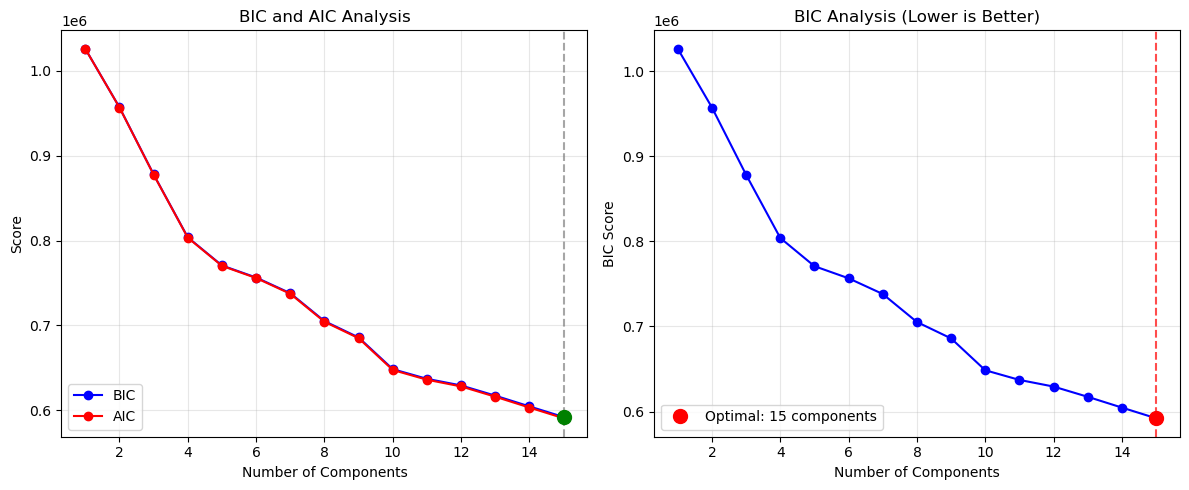


Fitting final GMM with 15 components...


In [ ]:
# Prepare features for GMM
features = segment_points[['x', 'y', 'z']].values

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# BIC Analysis to determine optimal number of components
print("\nPerforming BIC analysis...")

# Define range of components to test
min_components = 1
max_components = 15
n_components_range = range(min_components, max_components + 1)

bic_scores = []
aic_scores = []
gmm_models = []

for n_components in n_components_range:
    print(f"Fitting GMM with {n_components} components...")
    
    # Fit GMM with different initialization to avoid local minima
    best_gmm = None
    best_lower_bound = -np.inf
    
    for init in range(3):  # Try 3 different initializations
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            random_state=init,
            init_params='kmeans'
        )
        gmm.fit(scaled_features)
        
        if gmm.lower_bound_ > best_lower_bound:
            best_lower_bound = gmm.lower_bound_
            best_gmm = gmm
    
    bic_scores.append(best_gmm.bic(scaled_features))
    aic_scores.append(best_gmm.aic(scaled_features))
    gmm_models.append(best_gmm)
    
    print(f"  Components: {n_components}, BIC: {bic_scores[-1]:.2f}, AIC: {aic_scores[-1]:.2f}")

# Find optimal number of components (lowest BIC)
optimal_idx = np.argmin(bic_scores)
optimal_components = n_components_range[optimal_idx]

print(f"\nOptimal number of components based on BIC: {optimal_components}")
print(f"Minimum BIC value: {bic_scores[optimal_idx]:.2f}")

# Plot BIC and AIC scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, 'bo-', label='BIC')
plt.plot(n_components_range, aic_scores, 'ro-', label='AIC')
plt.axvline(x=optimal_components, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the optimal point
plt.plot(optimal_components, bic_scores[optimal_idx], 'go', markersize=10, label=f'Optimal (BIC): {optimal_components}')

plt.subplot(1, 2, 2)
# Plot just BIC for clarity
plt.plot(n_components_range, bic_scores, 'bo-')
plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Analysis (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.plot(optimal_components, bic_scores[optimal_idx], 'ro', markersize=10, 
         label=f'Optimal: {optimal_components} components')
plt.legend()

plt.tight_layout()
plt.show()

# Fit final model with optimal number of components
print(f"\nFitting final GMM with {optimal_components} components...")
final_gmm = gmm_models[optimal_idx]

# Predict clusters
cluster_labels = final_gmm.predict(scaled_features)
segment_points['gmm_cluster'] = cluster_labels

Fitting 1 folds for each of 192 candidates, totalling 192 fits
Best parameters: {'covariance_type': 'full', 'n_components': 49}
Best (lowest) BIC: 7118650.91834606
Best parameters: {'covariance_type': 'full', 'n_components': 49}
Best (lowest) BIC: 7118650.91834606


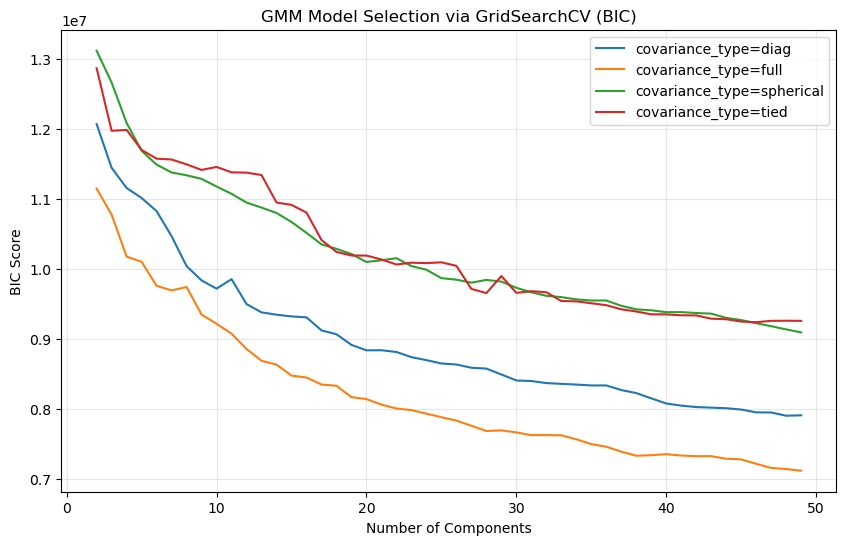

In [26]:
# GridSearchCV for GMM model selection using BIC

# Prepare features for GMM
features = sampled_points[['x', 'y', 'z']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Custom BIC scorer (lower is better, so we use negative BIC)
def bic_scorer(estimator, X):
    return -estimator.bic(X)

param_grid = {
    'n_components': np.arange(2, 50),
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

# Use integer indices for cv to avoid ValueError
cv_indices = [(np.arange(len(scaled_features)), np.arange(len(scaled_features)))]

search = GridSearchCV(
    GaussianMixture(random_state=42, init_params='kmeans'),
    param_grid,
    scoring=bic_scorer,
    cv=cv_indices,
    verbose=2,
    n_jobs=-1
)
search.fit(scaled_features)

print('Best parameters:', search.best_params_)
print('Best (lowest) BIC:', -search.best_score_)

# Plot BIC scores for each covariance type
results = search.cv_results_
bics = -results['mean_test_score']
components = results['param_n_components'].data
cov_types = results['param_covariance_type'].data

plt.figure(figsize=(10, 6))
for cov in np.unique(cov_types):
    mask = cov_types == cov
    plt.plot(components[mask], bics[mask], label=f'covariance_type={cov}')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('GMM Model Selection via GridSearchCV (BIC)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
# Faster BGMM: fit on a subset (optional) + diag covariances + fewer iterations
from sklearn.mixture import BayesianGaussianMixture
import time

# Use only x, y, z coordinates
features_segment = segment_points[['x', 'y', 'z']].values

# Standardize features
scaler = StandardScaler()
scaled_features_segment = scaler.fit_transform(features_segment)

# Option: fit on a random subset to speed up training (prediction on full data is cheap)
fit_on_subset = True  # set False to fit on full data
subset_size = min(50000, len(scaled_features_segment))  # adjust as needed
rng = np.random.default_rng(42)
if fit_on_subset and len(scaled_features_segment) > subset_size:
    idx = rng.choice(len(scaled_features_segment), size=subset_size, replace=False)
    fit_X = scaled_features_segment[idx]
    print(f'Fitting on subset of {len(fit_X):,} points (of {len(scaled_features_segment):,})')
else:
    fit_X = scaled_features_segment
    print(f'Fitting on full data of {len(fit_X):,} points')

# Faster BGMM configuration: 'diag' or 'spherical' covariance is much faster than 'full'
max_components = 30
bgmm = BayesianGaussianMixture(
    n_components=max_components,
    covariance_type='diag',  # 'diag' or 'spherical' are faster
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,  # increase for faster, sparser solutions
    max_iter=300,  # reduce iterations (tune if needed)
    tol=1e-2,  # larger tolerance allows earlier stopping
    n_init=2,  # fewer initializations speeds up fit
    init_params='kmeans',
    random_state=42,
)

t0 = time.time()
bgmm.fit(fit_X)
print(f'BGMM fit time: {time.time() - t0:.1f}s')

# Inspect weights and determine effective components (threshold can be tuned)
weights = bgmm.weights_
effective_components = int((weights > 1e-3).sum())
print(f'Effective components (weights > 1e-3): {effective_components}')
print('Top component weights (descending):', np.sort(weights)[::-1][:10])

# Predict cluster labels for the appropriate set of points (prediction is cheap relative to fit)
labels_bgmm = bgmm.predict(scaled_features_segment)

# Safely assign predicted labels to the matching DataFrame
if 'segment_points' in globals() and len(labels_bgmm) == len(segment_points):
    segment_points['gmm_cluster'] = labels_bgmm
    print(f"Assigned BGMM labels to `segment_points` ({len(labels_bgmm)} rows)")
elif 'points' in globals() and len(labels_bgmm) == len(points):
    points['gmm_cluster'] = labels_bgmm
    # If segment_points is a subset of points, copy labels across
    try:
        if set(segment_points.index).issubset(set(points.index)):
            segment_points['gmm_cluster'] = points.loc[segment_points.index, 'gmm_cluster'].values
    except Exception:
        pass
    print(f"Assigned BGMM labels to `points` ({len(labels_bgmm)} rows)")
else:
    raise ValueError(f"Length of predicted labels ({len(labels_bgmm)}) does not match `segment_points` ({len(segment_points) if 'segment_points' in globals() else 'N/A'}) or `points` ({len(points) if 'points' in globals() else 'N/A'})")

# Plot component weights to visualize sparsity
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
sorted_weights = np.sort(weights)[::-1]
# Use a try/except to support older matplotlib versions that lack the
# `use_line_collection` keyword in `stem()`
try:
    plt.stem(range(len(sorted_weights)), sorted_weights, use_line_collection=True)
except TypeError:
    plt.stem(range(len(sorted_weights)), sorted_weights)
plt.xlabel('Component (sorted by weight)')
plt.ylabel('Weight')
plt.title('BGMM component weights (descending)')
plt.tight_layout()
plt.show()

# Optionally, examine the means of the dominant components
dominant_idx = np.argsort(weights)[::-1][:effective_components]
print('Dominant component means (in standardized space):')
for i in dominant_idx[:10]:
    print(i, bgmm.means_[i])

Fitting on subset of 100,000 points (of 15,659,171)
BGMM fit time: 66.8s
Effective components (weights > 1e-3): 30
Top component weights (descending): [0.08392577 0.07149144 0.07054061 0.06272657 0.06136005 0.04815693
 0.04761327 0.04529209 0.04499586 0.04317314]
BGMM fit time: 66.8s
Effective components (weights > 1e-3): 30
Top component weights (descending): [0.08392577 0.07149144 0.07054061 0.06272657 0.06136005 0.04815693
 0.04761327 0.04529209 0.04499586 0.04317314]


ValueError: Length of values (15659171) does not match length of index (1351503)

In [ ]:
# Simple script to run GMM with chosen number of segments and covariance type on a sample
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# User parameters
n_segments = 49  # Set desired number of clusters
cov_type = 'full'  # Options: 'full', 'tied', 'diag', 'spherical'

# Prepare features from the sample
features = sampled_points[['x', 'y', 'z']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit GMM on the sample
gmm = GaussianMixture(n_components=n_segments, covariance_type=cov_type, random_state=42, init_params='kmeans')
gmm.fit(scaled_features)

# Predict clusters and assign to the sampled DataFrame
sampled_points['gmm_cluster'] = gmm.predict(scaled_features)
print(f'GMM fit complete. Assigned {n_segments} clusters using covariance type "{cov_type}" to the sample.')

ValueError: Length of values (1565917) does not match length of index (1351503)

c:\Users\jlncr\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


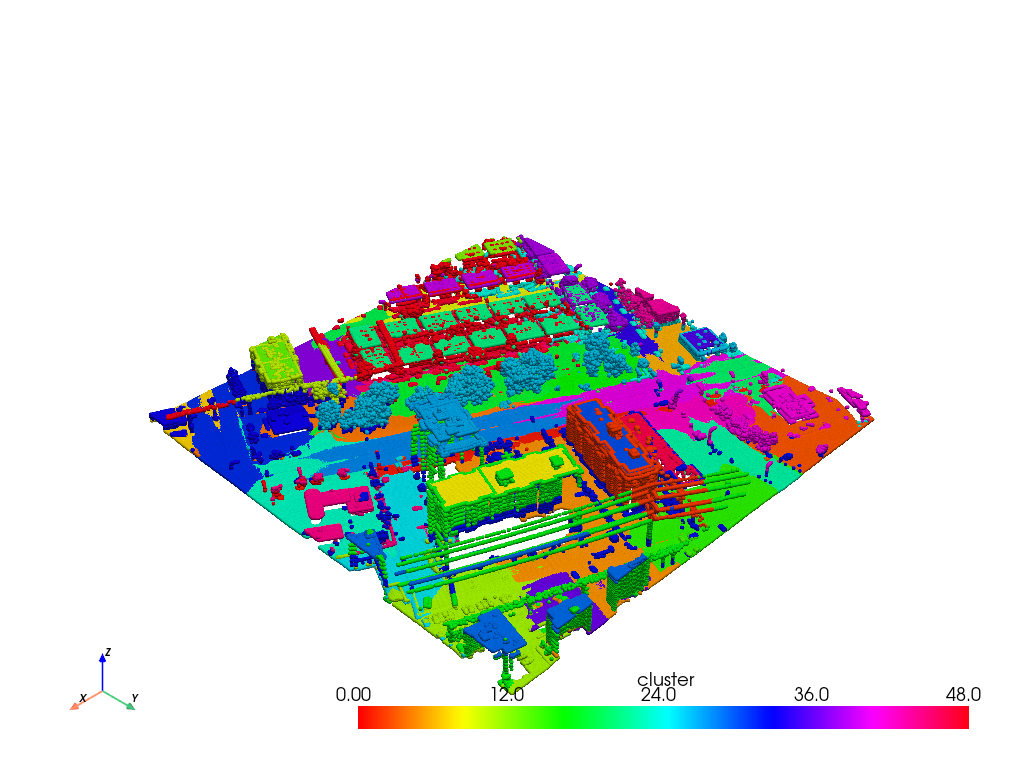

In [28]:
# Visualize clustering using PyVista only
import pyvista as pv
import numpy as np

# Build a PyVista point cloud and render with cluster scalars
xyz = segment_points[['x', 'y', 'z']].values
clusters = segment_points['gmm_cluster'].astype(int).values
cloud = pv.PolyData(xyz)
cloud['cluster'] = clusters
plotter = pv.Plotter()
n_clusters = int(np.unique(clusters).size)
cmap_name = 'tab20' if n_clusters <= 20 else 'hsv'
plotter.add_mesh(cloud, scalars='cluster', render_points_as_spheres=True, point_size=4, cmap=cmap_name)
plotter.add_axes()
plotter.show()